# Step 1: Load and inspect dataset


In [3]:
import pandas as pd


file_path = '/content/Sepsis Prediction.csv'
df = pd.read_csv(file_path)


print(df.head())
print(df.columns)
print(df.shape)


   Unnamed: 0  Hour    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  ...  \
0           0     0   NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN  ...   
1           1     1  65.0  100.0   NaN    NaN  72.0   NaN  16.5    NaN  ...   
2           2     2  78.0  100.0   NaN    NaN  42.5   NaN   NaN    NaN  ...   
3           3     3  73.0  100.0   NaN    NaN   NaN   NaN  17.0    NaN  ...   
4           4     4  70.0  100.0   NaN  129.0  74.0  69.0  14.0    NaN  ...   

   Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0         NaN        NaN  68.54       0    NaN    NaN        -0.02       1   
1         NaN        NaN  68.54       0    NaN    NaN        -0.02       2   
2         NaN        NaN  68.54       0    NaN    NaN        -0.02       3   
3         NaN        NaN  68.54       0    NaN    NaN        -0.02       4   
4         NaN      330.0  68.54       0    NaN    NaN        -0.02       5   

   SepsisLabel  Patient_ID  
0            0       17072 

# Timestamp in datetime

In [4]:

df.rename(columns={'Patient_ID':'patient_id', 'Hour':'charttime'}, inplace=True)


df['charttime'] = pd.to_numeric(df['charttime'], errors='coerce')


print(df[['patient_id','charttime','SepsisLabel']].dtypes)
print(df.head())




patient_id     int64
charttime      int64
SepsisLabel    int64
dtype: object
   Unnamed: 0  charttime    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  \
0           0          0   NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN   
1           1          1  65.0  100.0   NaN    NaN  72.0   NaN  16.5    NaN   
2           2          2  78.0  100.0   NaN    NaN  42.5   NaN   NaN    NaN   
3           3          3  73.0  100.0   NaN    NaN   NaN   NaN  17.0    NaN   
4           4          4  70.0  100.0   NaN  129.0  74.0  69.0  14.0    NaN   

   ...  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  ...         NaN        NaN  68.54       0    NaN    NaN        -0.02   
1  ...         NaN        NaN  68.54       0    NaN    NaN        -0.02   
2  ...         NaN        NaN  68.54       0    NaN    NaN        -0.02   
3  ...         NaN        NaN  68.54       0    NaN    NaN        -0.02   
4  ...         NaN      330.0  68.54       0    NaN    NaN        -0.02  

# Sort by patient and time

In [5]:
df = df.sort_values(by=['patient_id','charttime']).reset_index(drop=True)


In [6]:

print(df['SepsisLabel'].value_counts())


SepsisLabel
0    1524294
1      27916
Name: count, dtype: int64


# Step 2: Create early-warning labels (EW_Label)

In [7]:
import numpy as np

HORIZON = 6


df_windowed = df.copy()
df_windowed['EW_Label'] = 0

# Group by patient
for pid, group in df_windowed.groupby('patient_id'):
    sepsis_times = group.loc[group['SepsisLabel']==1, 'charttime'].values
    if len(sepsis_times) == 0:
        continue  # no sepsis for this patient

    # Vectorized check: for each row, see if any sepsis happens within horizon
    charttimes = group['charttime'].values[:, None]  # shape (n_rows,1)
    mask = np.any((sepsis_times > charttimes) & (sepsis_times <= charttimes + HORIZON), axis=1)
    df_windowed.loc[group.index, 'EW_Label'] = mask.astype(int)

# Check results
print(df_windowed[['patient_id','charttime','SepsisLabel','EW_Label']].head(20))
print(df_windowed['EW_Label'].value_counts())



    patient_id  charttime  SepsisLabel  EW_Label
0            1          0            0         0
1            1          1            0         0
2            1          2            0         0
3            1          3            0         0
4            1          4            0         0
5            1          5            0         0
6            1          6            0         0
7            1          7            0         0
8            1          8            0         0
9            1          9            0         0
10           1         10            0         0
11           1         11            0         0
12           1         12            0         0
13           1         13            0         0
14           1         14            0         0
15           1         15            0         0
16           1         16            0         0
17           1         17            0         0
18           1         18            0         0
19           1      

# Step 3: Prepare features and train/test split

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


feature_cols = [
    'HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2','BaseExcess','HCO3',
    'FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride',
    'Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium','Phosphate',
    'Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen',
    'Platelets','Age','Gender'
]

X = df_windowed[feature_cols]
y = df_windowed['EW_Label']


imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=feature_cols)

patients = df_windowed['patient_id'].unique()
train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)

X_train = X_scaled[df_windowed['patient_id'].isin(train_patients)]
y_train = y[df_windowed['patient_id'].isin(train_patients)]
X_test = X_scaled[df_windowed['patient_id'].isin(test_patients)]
y_test = y[df_windowed['patient_id'].isin(test_patients)]


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train class distribution:\n", y_train.value_counts())
print("y_test class distribution:\n", y_test.value_counts())


X_train shape: (1241213, 36)
X_test shape: (310997, 36)
y_train class distribution:
 EW_Label
0    1209480
1      31733
Name: count, dtype: int64
y_test class distribution:
 EW_Label
0    303667
1      7330
Name: count, dtype: int64


# Step 4: Train LightGBM model

In [9]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score


train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': ['auc', 'average_precision'],
    'is_unbalance': True,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'max_depth': 7,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}


bst = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, test_data],
    valid_names=['train','test'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)


y_pred_proba = bst.predict(X_test)
roc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"Test AUROC: {roc:.4f}")
print(f"Test PR-AUC: {pr_auc:.4f}")


Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.714729	train's average_precision: 0.0877609	test's auc: 0.685727	test's average_precision: 0.0572215
[100]	train's auc: 0.735933	train's average_precision: 0.104805	test's auc: 0.689453	test's average_precision: 0.0586004
[150]	train's auc: 0.749402	train's average_precision: 0.11826	test's auc: 0.691354	test's average_precision: 0.0593775
[200]	train's auc: 0.761417	train's average_precision: 0.130852	test's auc: 0.691034	test's average_precision: 0.0592341
Early stopping, best iteration is:
[155]	train's auc: 0.750919	train's average_precision: 0.119697	test's auc: 0.691588	test's average_precision: 0.0594028
Test AUROC: 0.6916
Test PR-AUC: 0.0594


# Step 5: Global SHAP feature importance

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


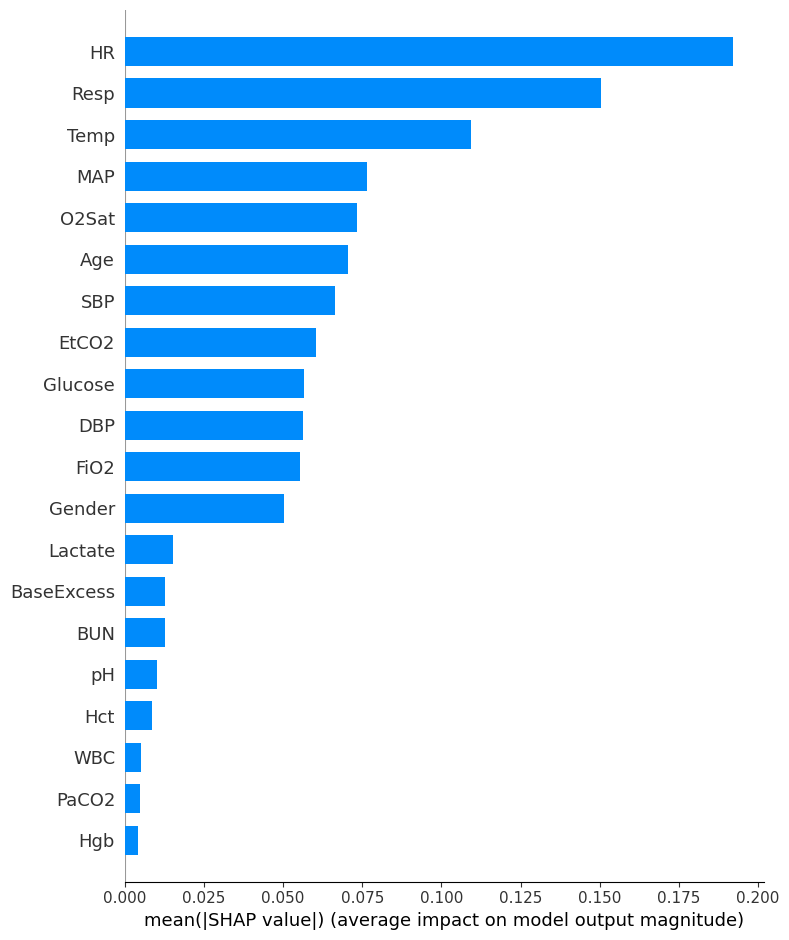

In [10]:
import shap


explainer = shap.TreeExplainer(bst)

X_sample = X_test.sample(5000, random_state=42)


shap_values_sample = explainer.shap_values(X_sample)


shap.summary_plot(shap_values_sample, X_sample, plot_type="bar")



In [12]:
y_pred_proba = bst.predict(X_test)


# Step 6: Single-patient SHAP explanations

In [15]:
import shap

shap.initjs()


single_patient = X_test.iloc[0:1]


shap_values_patient = explainer.shap_values(single_patient)


if isinstance(shap_values_patient, list):

    shap_vals = shap_values_patient[0]
    expected_val = explainer.expected_value[0]
else:
    shap_vals = shap_values_patient
    expected_val = explainer.expected_value


shap.force_plot(expected_val, shap_vals, single_patient)





/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



SHAP explanation for patient index 227352 (predicted probability: 0.940):


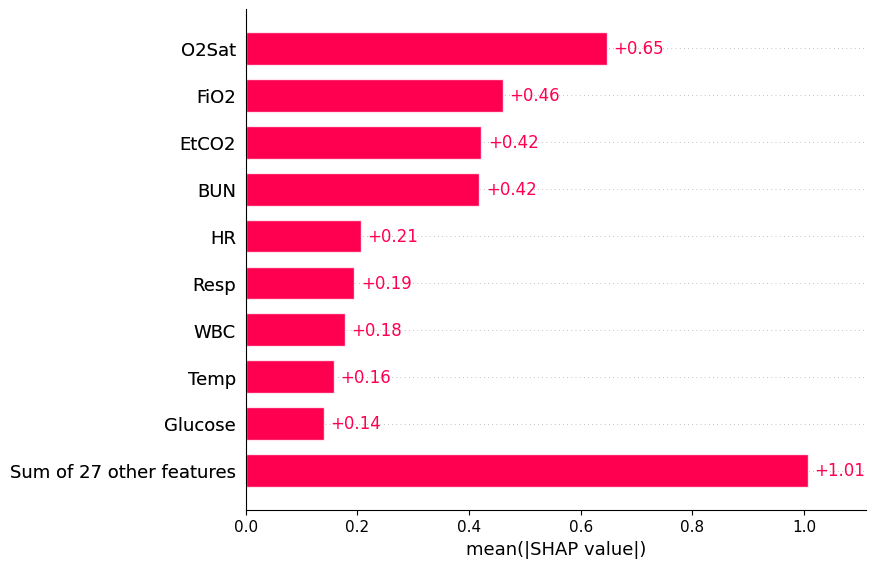

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



SHAP explanation for patient index 161918 (predicted probability: 0.931):


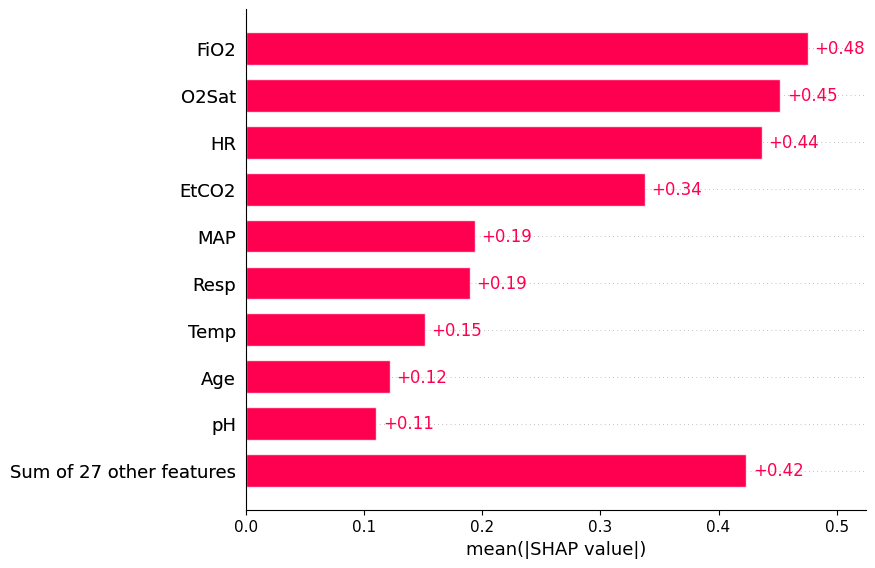

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



SHAP explanation for patient index 270949 (predicted probability: 0.925):


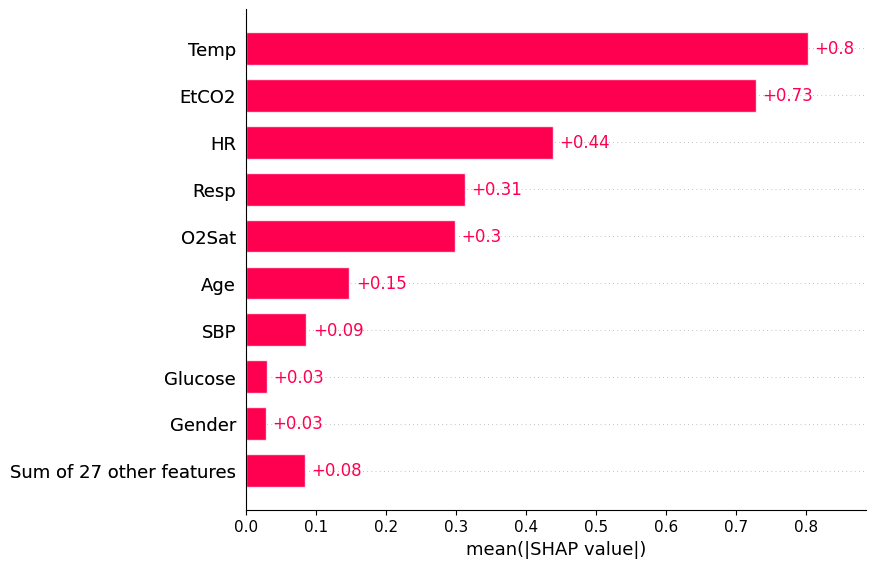

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



SHAP explanation for patient index 309928 (predicted probability: 0.028):


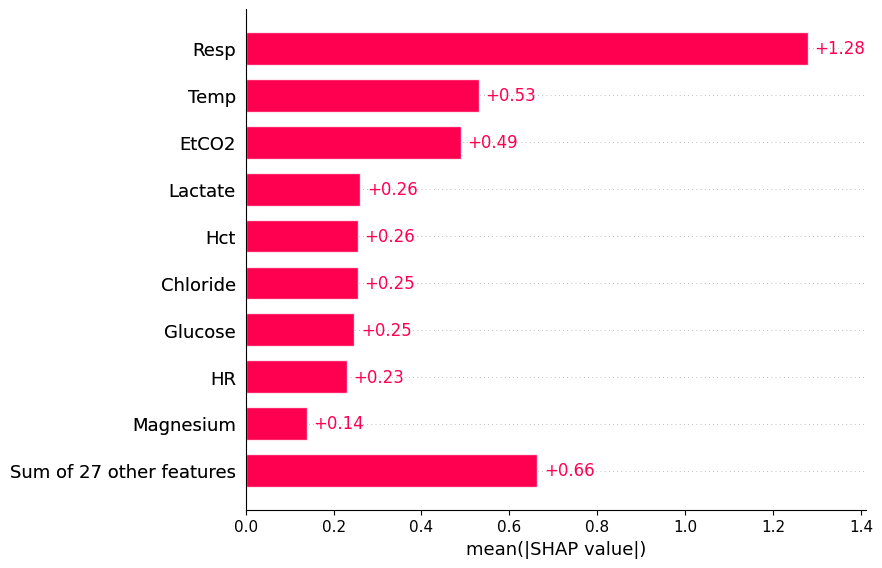

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



SHAP explanation for patient index 195470 (predicted probability: 0.035):


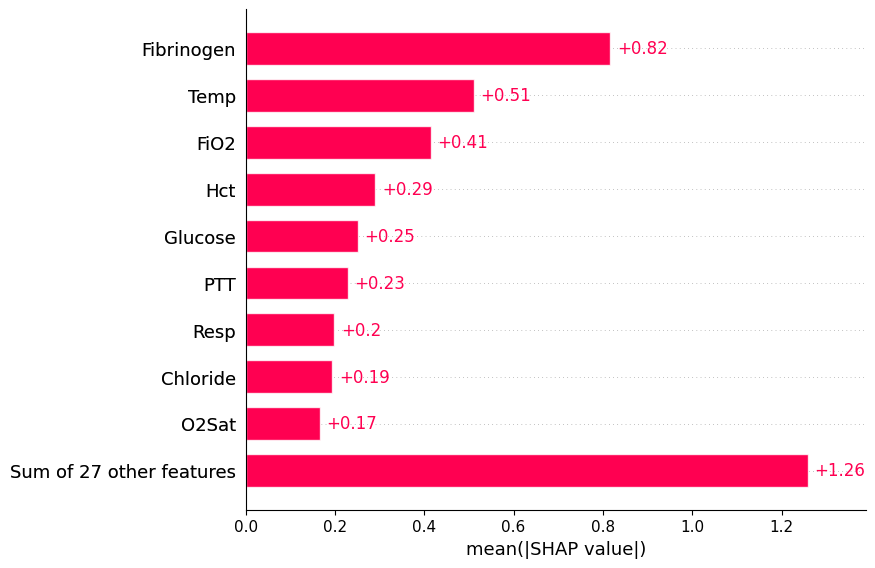

In [17]:
import shap
import numpy as np


shap.initjs()

# Predict probabilities for all test patients
y_pred_proba = bst.predict(X_test)

# Sort indices
highest_risk_idx = y_pred_proba.argsort()[-3:][::-1]  # top 3 patients
lowest_risk_idx = y_pred_proba.argsort()[:2]          # bottom 2 patients
selected_idx = list(highest_risk_idx) + list(lowest_risk_idx)

# Loop over selected patients
for idx in selected_idx:
    patient = X_test.iloc[idx:idx+1]

    # Compute SHAP values
    shap_values_patient = explainer.shap_values(patient)

    # Handle list/array output
    if isinstance(shap_values_patient, list):
        shap_vals = shap_values_patient[0]
        expected_val = explainer.expected_value[0]
    else:
        shap_vals = shap_values_patient
        expected_val = explainer.expected_value

    # Wrap in Explanation object for static plotting
    shap_expl = shap.Explanation(values=shap_vals,
                                 base_values=expected_val,
                                 data=patient.values,
                                 feature_names=patient.columns)

    # Static bar plot
    print(f"\nSHAP explanation for patient index {idx} (predicted probability: {y_pred_proba[idx]:.3f}):")
    shap.plots.bar(shap_expl, max_display=10)


# Model Evaluation and Metrics

Test AUROC: 0.6916
Test PR-AUC: 0.0594


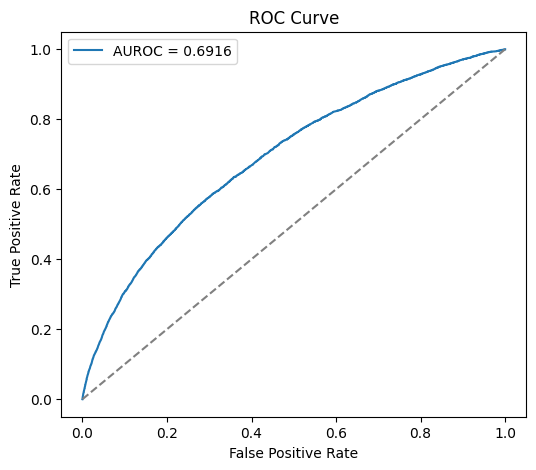

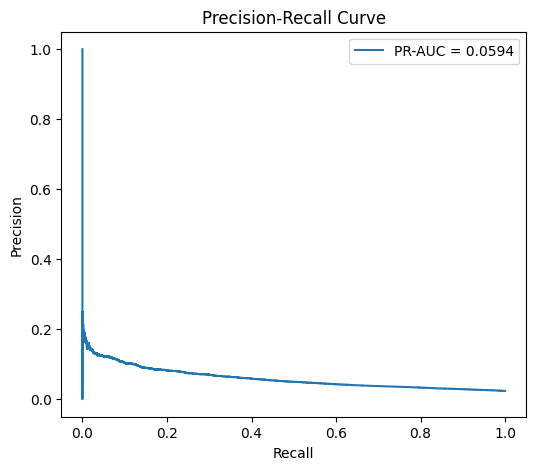

Confusion Matrix (threshold=0.5):
[[225520  78147]
 [  3435   3895]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9850    0.7427    0.8468    303667
           1     0.0475    0.5314    0.0872      7330

    accuracy                         0.7377    310997
   macro avg     0.5162    0.6370    0.4670    310997
weighted avg     0.9629    0.7377    0.8289    310997



In [19]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred_proba = bst.predict(X_test)


roc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
print(f"Test AUROC: {roc:.4f}")
print(f"Test PR-AUC: {pr_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUROC = {roc:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


threshold = 0.5
y_pred_class = (y_pred_proba >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix (threshold=0.5):")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, digits=4))

